In [12]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

In [22]:

paths = {
    "nrcb-py":     "../data/py-seq/nrcb/nrcb-py.csv",
    "nrcb-siril":     "../data/py-seq/nrcb/nrcb-siril.csv",
    "nrcblong-py": "../data/py-seq/nrcblong/nrcblong-py.csv",
    "nrcblong-siril": "../data/py-seq/nrcblong/nrcblong-siril.csv",
}

def load_table(path, label):
    df = pd.read_csv(path)
    # Приведём имена столбцов к валидным
    df = df.rename(columns={
        "Ch.": "Ch", "Ra": "RA", "Dec": "Dec",
        "FWHMx": "FWHMx", "FWHMy": "FWHMy",
        "Mag": "Mag", "Beta": "Beta", "r": "Roundness", "Angle": "Angle",
        "RMSE": "RMSE", "x0":"x0", "y0":"y0", "A":"A", "B":"B"
    })
    # Нормируем типы
    num_cols = ["Ch","B","A","x0","y0","RA","Dec","FWHMx","FWHMy","Mag","Beta","Roundness","Angle","RMSE"]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df["group"] = label
    return df

frames = []
for g, p in paths.items():
    frames.append(load_table(p, g))

data = pd.concat(frames, ignore_index=True)
len(data), data.columns.tolist()  # быстрый просмотр

(18669,
 ['Ch',
  'B',
  'A',
  'x0',
  'y0',
  'RA',
  'Dec',
  'FWHMx',
  'FWHMy',
  'Mag',
  'Beta',
  'Roundness',
  'Angle',
  'RMSE',
  'group'])

In [23]:
# Удалим строки без ключевых параметров
req = ["FWHMx", "FWHMy", "Roundness"]
clean = data.dropna(subset=[c for c in req if c in data.columns]).copy()

# Площадь эллипса на уровне FWHM: π * (FWHMx/2) * (FWHMy/2)  [в пикселях^2]
clean["Area_FWHM_px2"] = np.pi * (clean["FWHMx"] * clean["FWHMy"]) / 4.0

# Нормальная защита от мусора: отрицательные FWHM/площади выкинем
clean = clean[(clean["FWHMx"] > 0) & (clean["FWHMy"] > 0) & (clean["Area_FWHM_px2"] > 0)].copy()

# Приведём угол к радианам (если понадобится для PSF)
if "Angle" in clean.columns:
    clean["Angle_rad"] = np.deg2rad(clean["Angle"])
else:
    clean["Angle_rad"] = 0.0

clean.describe()[["FWHMx","FWHMy","Area_FWHM_px2","Roundness"]]

,FWHMx,FWHMy,Area_FWHM_px2,Roundness
count,18669.000000,18669.000000,18669.000000,18669.000000
mean,2.809585,2.444098,5.750585,0.898699
std,0.974092,0.554053,4.563820,0.119184
min,0.073429,0.060643,0.003497,0.500278
25%,2.311600,2.187600,4.004326,0.860291
50%,2.466200,2.311210,4.474405,0.944831
75%,2.846560,2.492510,5.572278,0.986279
max,14.174900,13.066200,134.729971,1.000000


In [24]:
# Cell 3
agg = (
    clean
    .groupby("group")
    .agg(
        roundness_mean=("Roundness","mean"),
        roundness_median=("Roundness","median"),
        area_median_px2=("Area_FWHM_px2","median"),
        fwhmx_median=("FWHMx","median"),
        fwhmy_median=("FWHMy","median"),
        beta_median=("Beta","median")
    )
    .reset_index()
)
agg

,group,roundness_mean,roundness_median,area_median_px2,fwhmx_median,fwhmy_median,beta_median
0,nrcb-py,0.904741,0.947113,4.372613,2.442260,2.28513,-1.0
1,nrcb-siril,0.895238,0.944037,4.577775,2.480380,2.32863,-1.0
2,nrcblong-py,0.898201,0.943155,4.430264,2.461565,2.30132,-1.0
3,nrcblong-siril,0.887700,0.937932,4.791470,2.546390,2.37122,-1.0


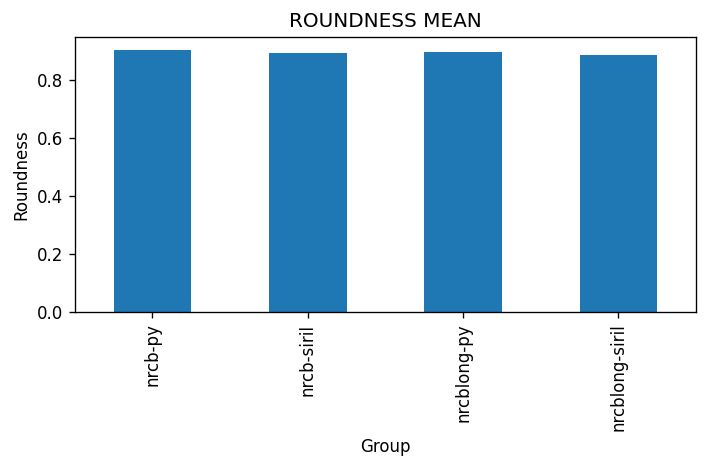

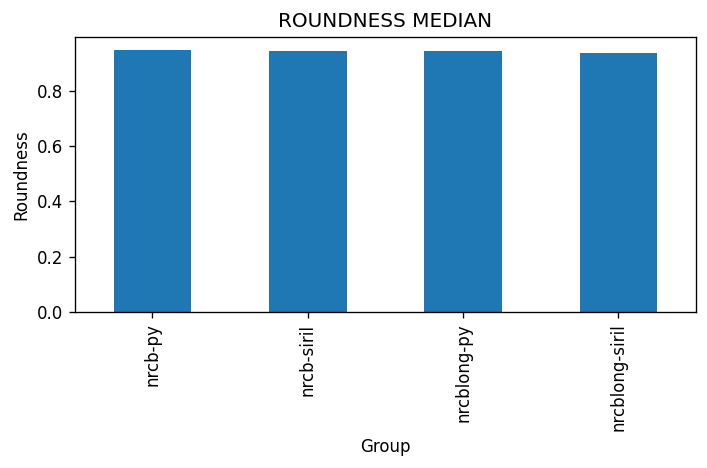

In [25]:
# Cell 4
for col in ["roundness_mean","roundness_median"]:
    plt.figure()
    tmp = agg.set_index("group")[col]
    tmp.plot(kind="bar")
    plt.title(col.replace("_"," ").upper())
    plt.ylabel("Roundness")
    plt.xlabel("Group")
    plt.tight_layout()
    plt.show()

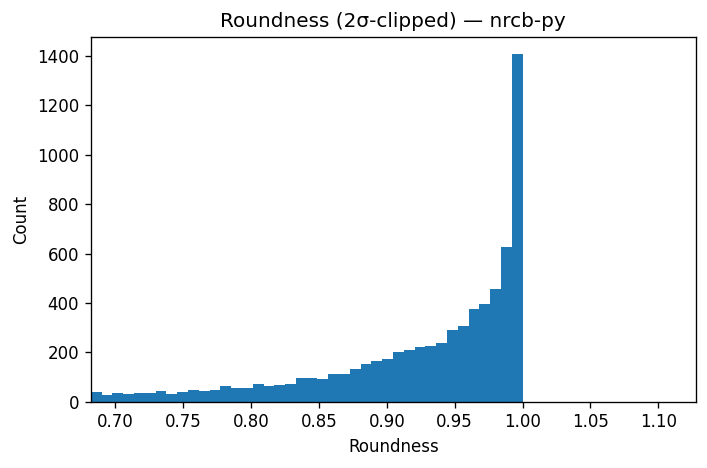

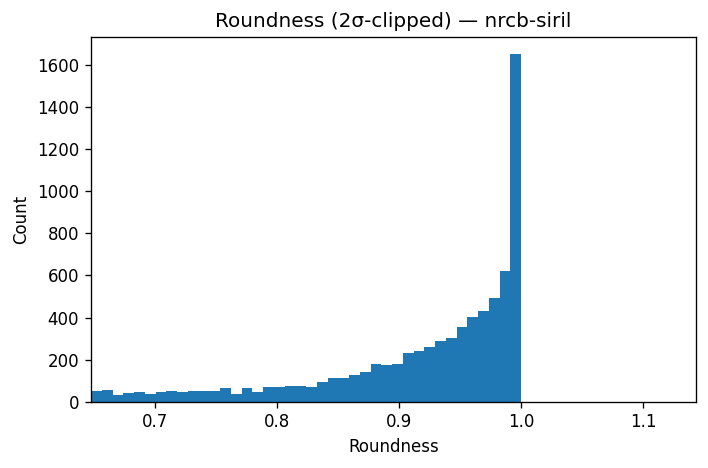

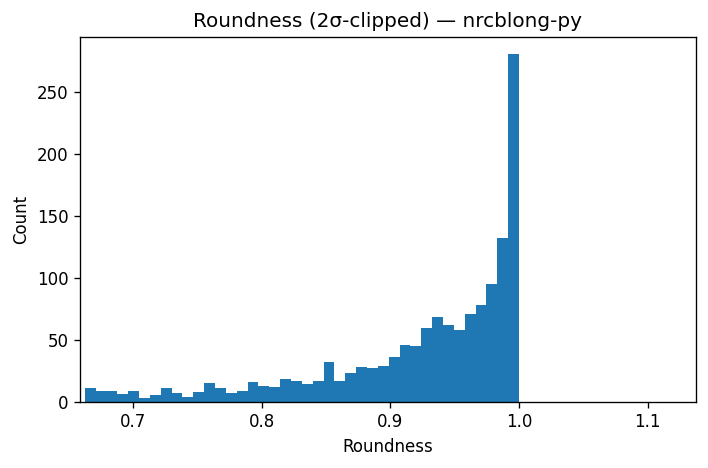

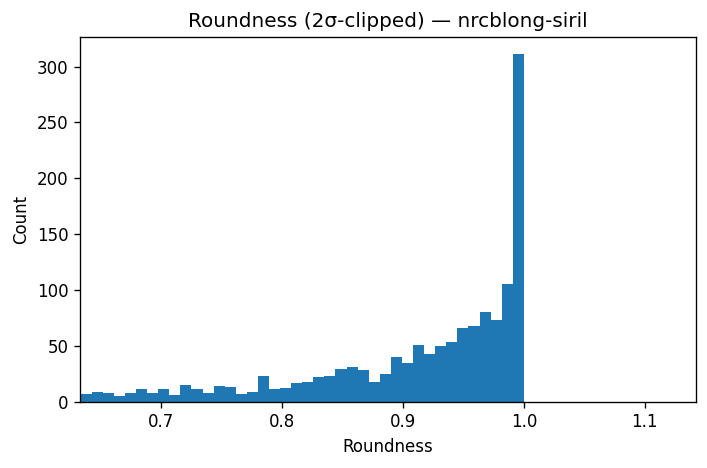

In [26]:
# Cell 5
def two_sigma_window(x: np.ndarray):
    """Возвращает (lo, hi) по правилу mean ± 2*std. Для неотрицательных метрик lo>=0."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return (float(np.nanmin(x)) if x.size else 0.0,
                float(np.nanmax(x)) if x.size else 1.0)
    mu = float(np.mean(x))
    sd = float(np.std(x, ddof=1))
    lo = mu - 2*sd
    hi = mu + 2*sd
    if np.all(x >= 0):
        lo = max(lo, 0.0)
    if not np.isfinite(lo): lo = float(np.nanmin(x))
    if not np.isfinite(hi): hi = float(np.nanmax(x))
    if lo >= hi:  # вырожденный случай
        lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
    return lo, hi

for g, df in clean.groupby("group"):
    vals = df["Roundness"].dropna().values
    lo, hi = two_sigma_window(vals)
    vals_clip = vals[(vals >= lo) & (vals <= hi)]
    plt.figure()
    plt.hist(vals_clip, bins=40)
    plt.title(f"Roundness (2σ-clipped) — {g}")
    plt.xlabel("Roundness")
    plt.ylabel("Count")
    plt.xlim(lo, hi)
    plt.tight_layout()
    plt.show()

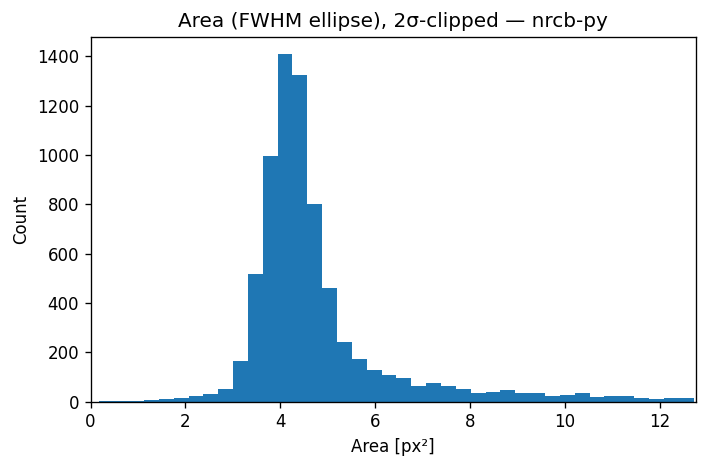

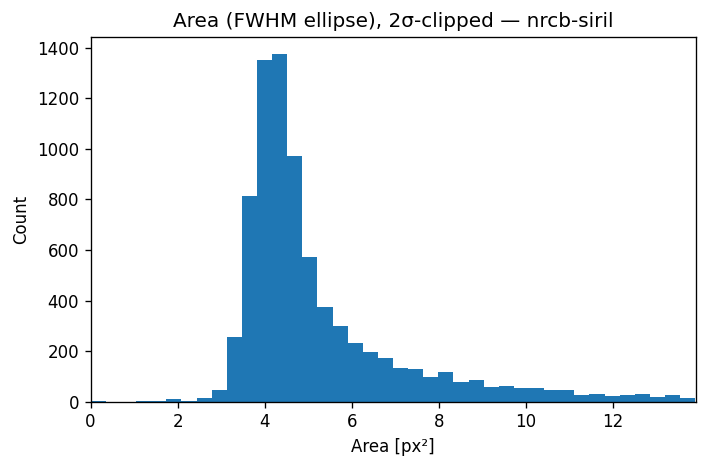

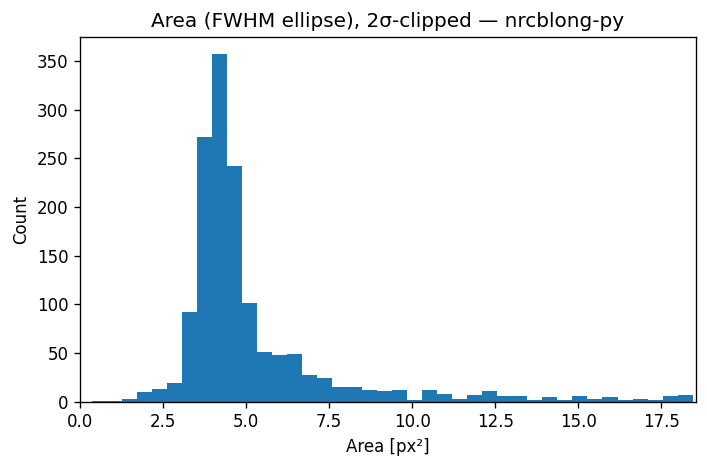

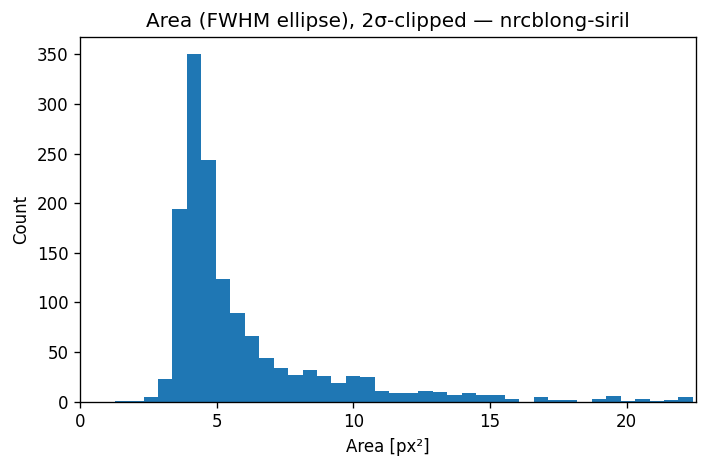

In [27]:
for g, df in clean.groupby("group"):
    vals = df["Area_FWHM_px2"].dropna().values
    lo, hi = two_sigma_window(vals)
    vals_clip = vals[(vals >= lo) & (vals <= hi)]
    plt.figure()
    plt.hist(vals_clip, bins=40)
    plt.title(f"Area (FWHM ellipse), 2σ-clipped — {g}")
    plt.xlabel("Area [px²]")
    plt.ylabel("Count")
    plt.xlim(lo, hi)
    plt.tight_layout()
    plt.show()

In [28]:

share = (
    clean
    .assign(is_round=lambda d: d["Roundness"] > 0.8)
    .groupby("group")["is_round"]
    .mean()
    .rename("share_roundness_gt_0_8")
    .reset_index()
)

# присоединим к agg, если он уже посчитан
agg = agg.merge(share, on="group", how="left")
display(agg)

,group,roundness_mean,roundness_median,area_median_px2,fwhmx_median,fwhmy_median,beta_median,share_roundness_gt_0_8
0,nrcb-py,0.904741,0.947113,4.372613,2.442260,2.28513,-1.0,0.846984
1,nrcb-siril,0.895238,0.944037,4.577775,2.480380,2.32863,-1.0,0.819948
2,nrcblong-py,0.898201,0.943155,4.430264,2.461565,2.30132,-1.0,0.830287
3,nrcblong-siril,0.887700,0.937932,4.791470,2.546390,2.37122,-1.0,0.798263


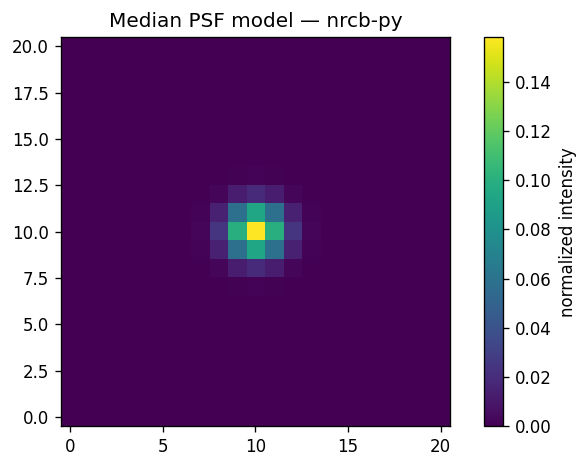

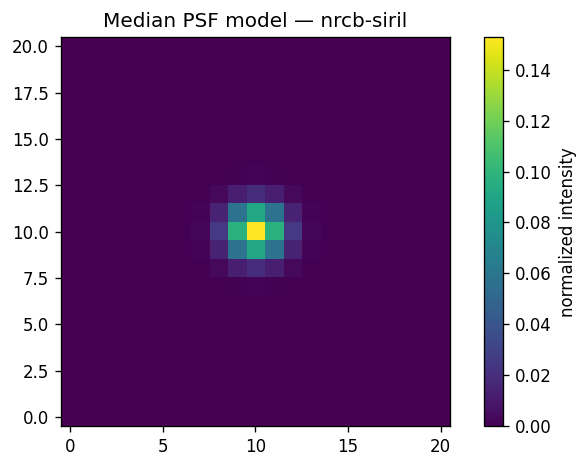

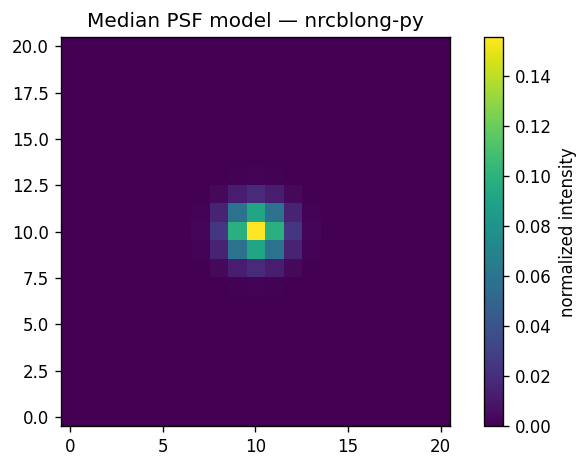

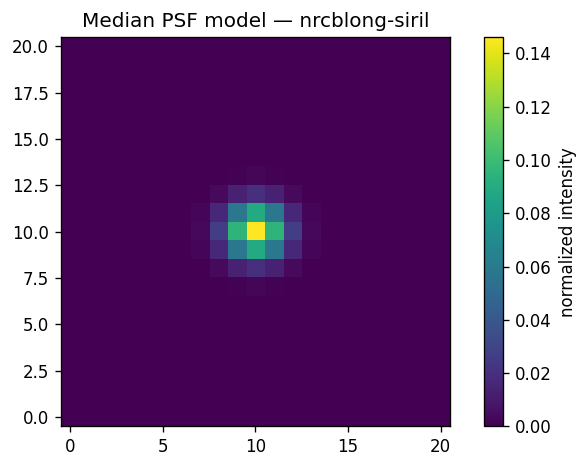

In [29]:
# Cell 7
def moffat_psf(nx, ny, fwhmx, fwhmy, beta, angle_rad, center=None):
    """Нормированная 2D Моффат по FWHM и beta, эллиптичная, с поворотом."""
    y, x = np.mgrid[0:ny, 0:nx]
    if center is None:
        cx, cy = (nx-1)/2.0, (ny-1)/2.0
    else:
        cx, cy = center
    # Преобразуем FWHM -> alpha по формуле: FWHM = 2*alpha*sqrt(2^(1/beta)-1)
    if beta <= 0:
        # выродим в гаусс позже
        beta = None
    if beta is not None:
        s = np.sqrt(2**(1.0/beta) - 1.0)
        alpha_x = (fwhmx / 2.0) / s
        alpha_y = (fwhmy / 2.0) / s
    else:
        alpha_x = alpha_y = None

    ca, sa = np.cos(angle_rad), np.sin(angle_rad)
    xr =  (x - cx)*ca + (y - cy)*sa
    yr = -(x - cx)*sa + (y - cy)*ca

    if alpha_x is None:
        # Гаусс: FWHM = 2*sqrt(2*ln2)*sigma ⇒ sigma = FWHM/2.3548
        sx = fwhmx / 2.3548
        sy = fwhmy / 2.3548
        z = np.exp(-0.5*((xr/sx)**2 + (yr/sy)**2))
    else:
        z = (1.0 + (xr/alpha_x)**2 + (yr/alpha_y)**2) ** (-beta)

    z = np.clip(z, 0, None)
    z /= z.sum() if z.sum() > 0 else 1.0
    return z

# Построим PSF по медианам для каждой группы
psf_stamp = {}
for _, row in agg.iterrows():
    g = row["group"]
    fwx = row["fwhmx_median"]
    fwy = row["fwhmy_median"]
    beta = row["beta_median"] if not np.isnan(row["beta_median"]) else -1
    # подберём разумный размер окна: ~ 8 * max(FWHM)
    size = int(max(21, math.ceil(8*max(fwx, fwy))))
    size = size + (size % 2 == 0)  # нечётный размер
    psf = moffat_psf(size, size, fwx, fwy, beta, angle_rad=0.0)  # угол медианный можно добавить при необходимости
    psf_stamp[g] = psf

# Визуализация PSF
for g, img in psf_stamp.items():
    plt.figure()
    plt.imshow(img, origin="lower")
    plt.title(f"Median PSF model — {g}")
    plt.colorbar(label="normalized intensity")
    plt.tight_layout()
    plt.show()